source: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_Pyro.ipynb


In [ ]:
pip install pyro-ppl

     |████████████████████████████████| 718 kB 5.1 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import torch
from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import SVI,Trace_ELBO
from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide  import AutoMultivariateNormal, AutoNormal, init_to_mean
from pyro.optim import ClippedAdam

assert pyro.__version__.startswith('1.8')
pyro.set_rng_seed(1)
torch.manual_seed(1)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 5]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv", header=None)
df.columns = ['messages_received']
df.loc[:,'day'] = df.index +1
df.head()

,messages_received,day
0,13.0,1
1,24.0,2
2,8.0,3
3,24.0,4
4,7.0,5


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
messages_received,74.0,19.743243,14.141226,0.0,11.00,17.0,23.00,72.0
day,74.0,37.500000,21.505813,1.0,19.25,37.5,55.75,74.0


You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. How would you model this data

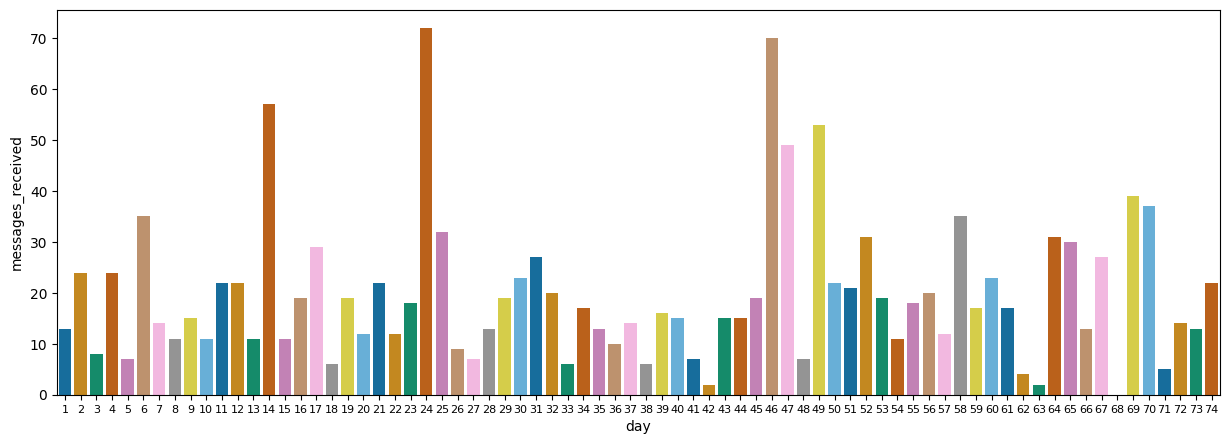

In [ ]:
sns.barplot(y='messages_received', x='day', data=df, palette='colorblind')
plt.xticks(fontsize=8);

Let's hypothesize that there is a switchpoint somewhere in the time series where the rate of texting increases. How can we find it with pyro?

In [ ]:
X = df.copy()

In [ ]:
X['messages_received'].mean(), X['messages_received'].std()

(19.743243243243242, 14.14122585879093)

In [ ]:
# Let's look at an actual poisson distribution fit to the mean of the data
samples = dist.Poisson(X['messages_received'].mean()).sample(tensor([74])) # create sample distribution where Poisson mean = data mean
sample_df = pd.DataFrame({'sample_texts_received':samples.numpy(), 'day':X['day'].copy()})

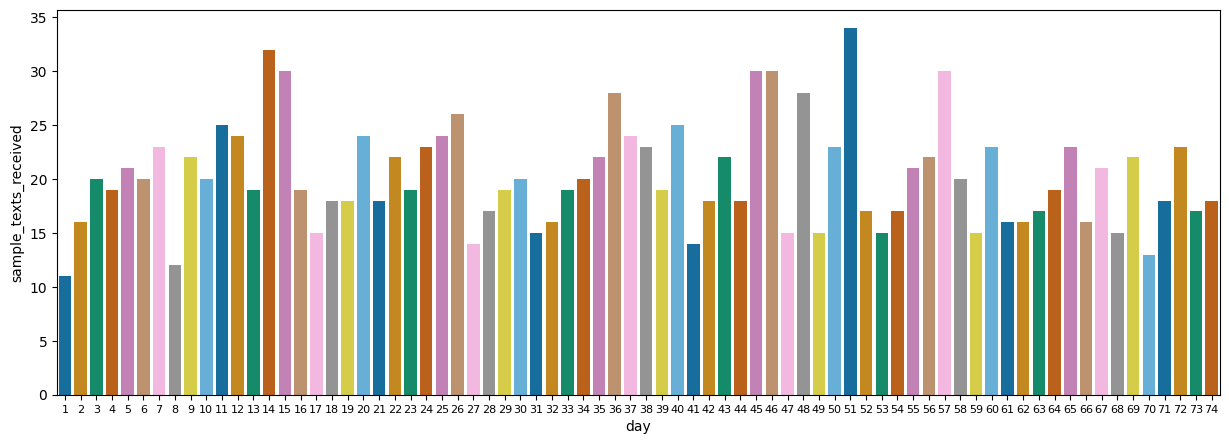

In [ ]:
sns.barplot(y='sample_texts_received', x='day', data=sample_df, palette='colorblind');
plt.xticks(fontsize=8);

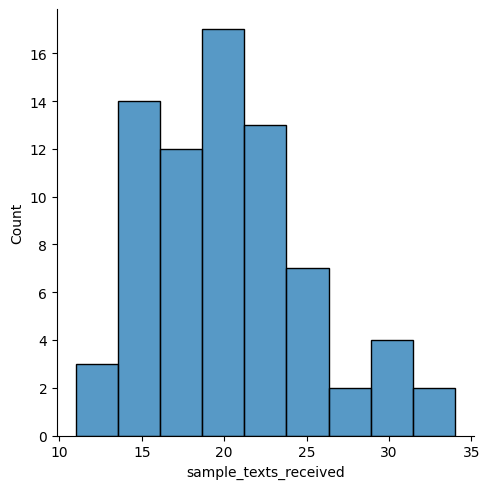

In [ ]:
sns.displot(x = sample_df['sample_texts_received']); #poisson distributed samples

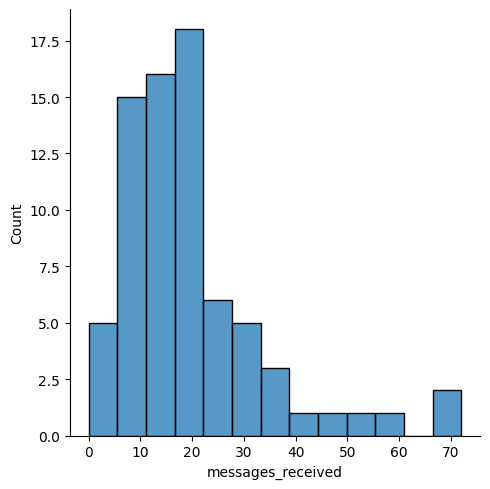

In [ ]:
sns.displot(x = df['messages_received']); #actuals

### So, comparing the actual data with the above two poisson sampling distributions above, it appears our data is overdispersed. Our data is heavily skewed to the right, ie., it has many more texts received far away from the mean, and much greater variability spikes much bigger than a poisson distribution would suggest.

In probability theory and statistics, the *gamma* distribution is a two-parameter family of continuous probability distributions. The exponential distribution, Erlang distribution, and chi-square distribution are special cases of the gamma distribution. 

There are two different parameterizations in common use:

With a shape parameter k and a scale parameter θ.

With a shape parameter α = k and an inverse scale parameter β = 1/θ, called a rate parameter.
In each of these forms, both parameters are positive real numbers.

with α = shape parameter, β = rate parameter

Mean = α/β

Variance = α/β²

In [ ]:
# Both Pytorch and Pyro use the concentration and rate parametrizations


In [ ]:
from pyro.distributions.torch import Gamma

m = Gamma(torch.tensor([1.]), torch.tensor([1.]))
m.sample()  # Gamma distributed with concentration=1 and rate=1

tensor([0.1167])

In [ ]:
a = tensor([0.5,1.,1.5,2.,2.5,3.]) #concentration parameters
b = tensor([0.25, 0.5, 1]) # rate parameters

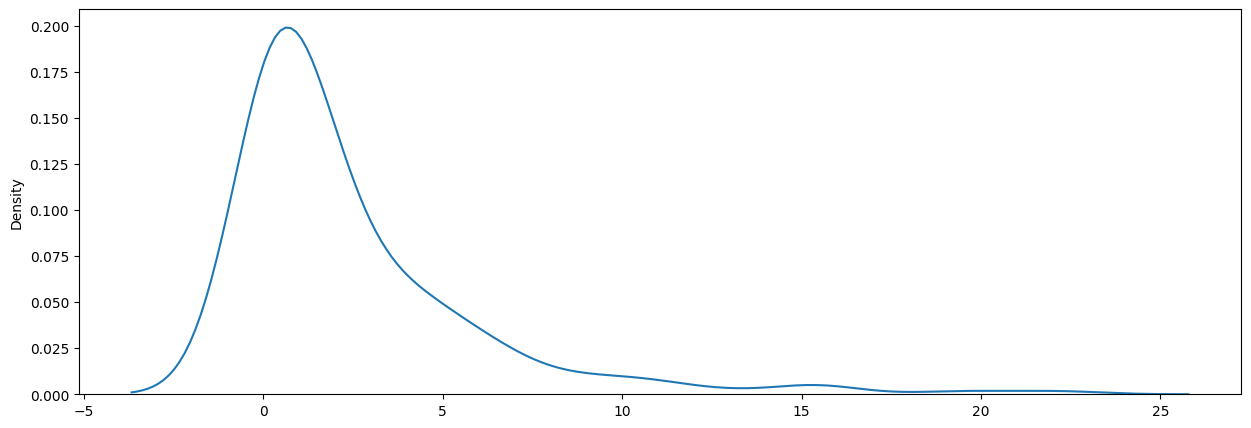

In [ ]:
sns.kdeplot(x=Gamma(0.5,0.25).sample(tensor([200])).numpy());

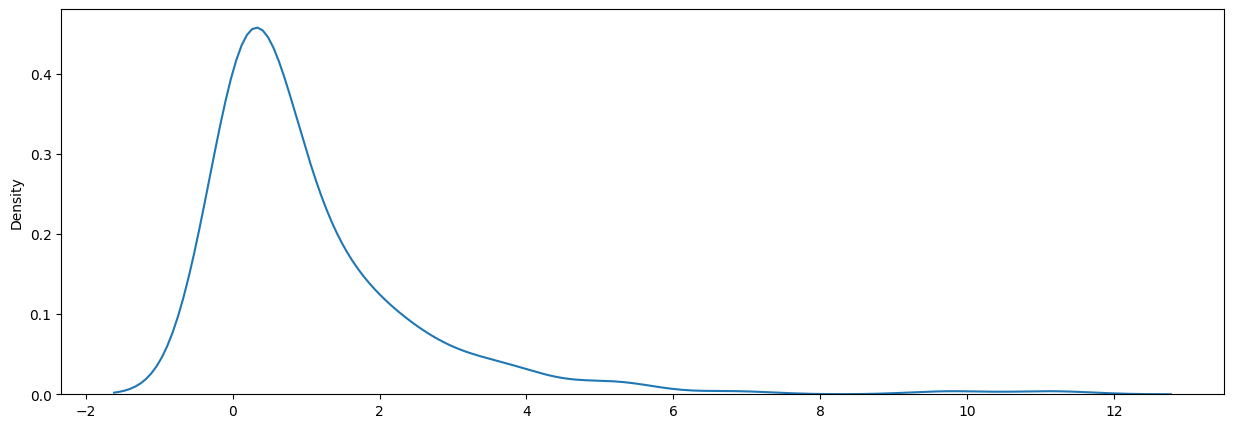

In [ ]:
sns.kdeplot(x=Gamma(0.5,0.5).sample(tensor([200])).numpy());

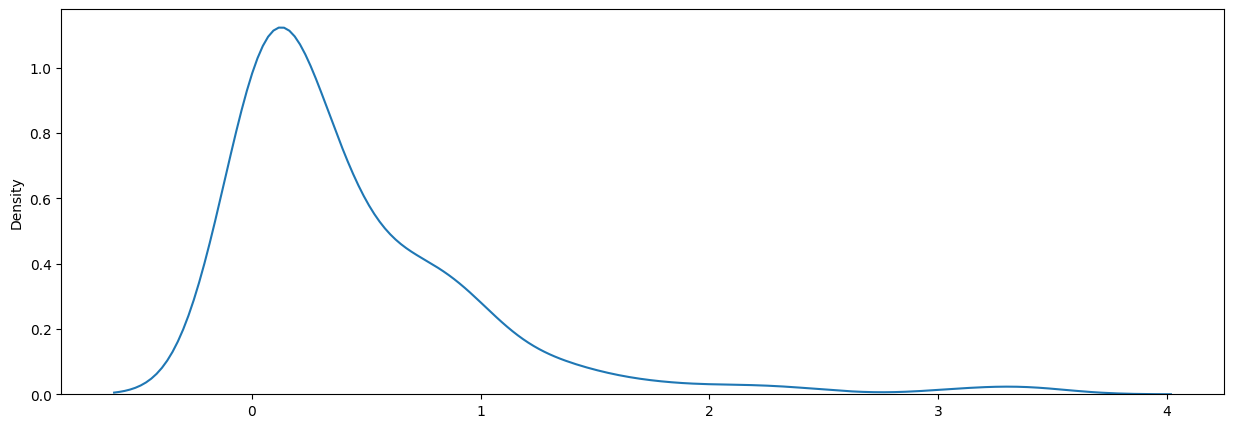

In [ ]:
sns.kdeplot(x=Gamma(0.5,1).sample(tensor([200])).numpy());

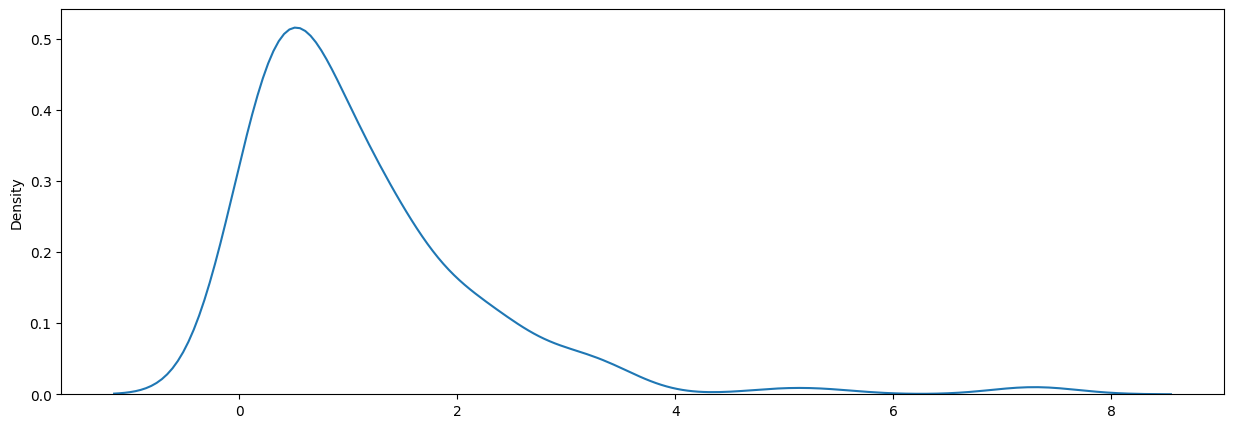

In [ ]:
sns.kdeplot(x=Gamma(1,1).sample(tensor([200])).numpy());

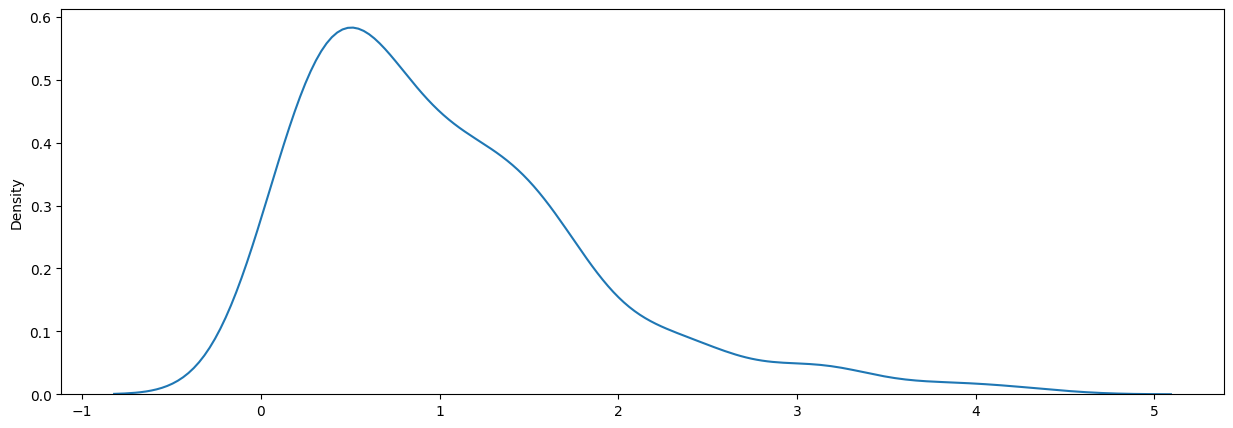

In [ ]:
sns.kdeplot(x=Gamma(1.5,1.5).sample(tensor([200])).numpy());

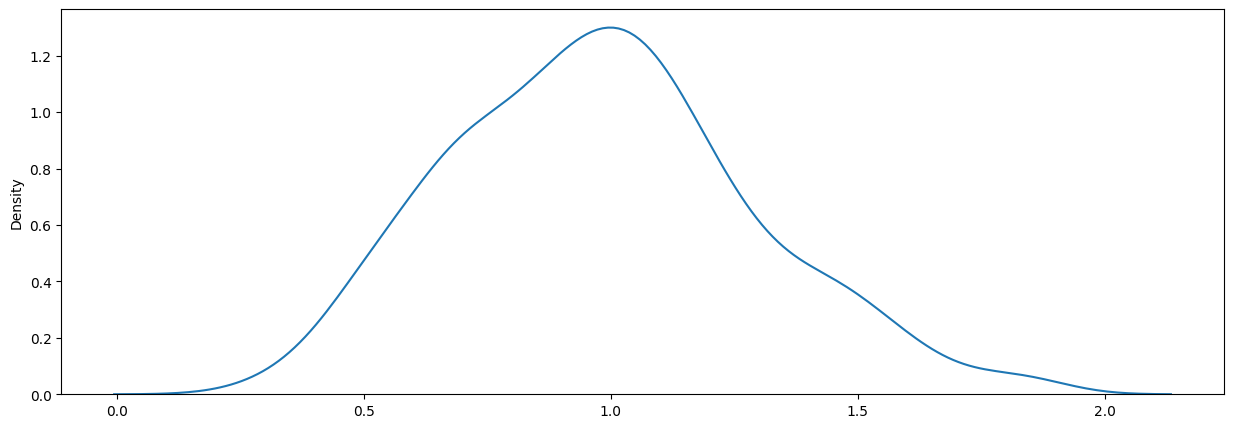

In [ ]:
sns.kdeplot(x=Gamma(10,10).sample(tensor([500])).numpy());

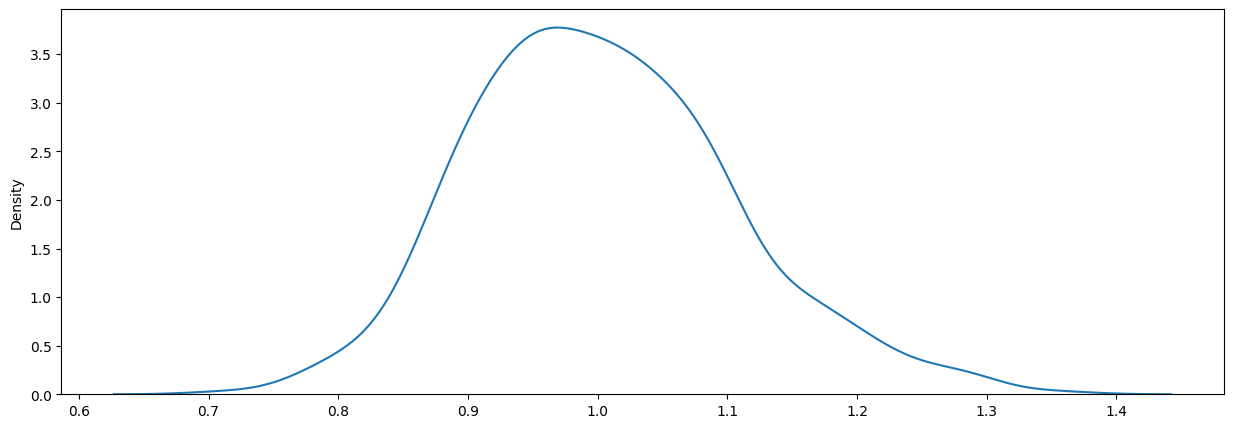

In [ ]:
sns.kdeplot(x=Gamma(100,100).sample(tensor([500])).numpy());

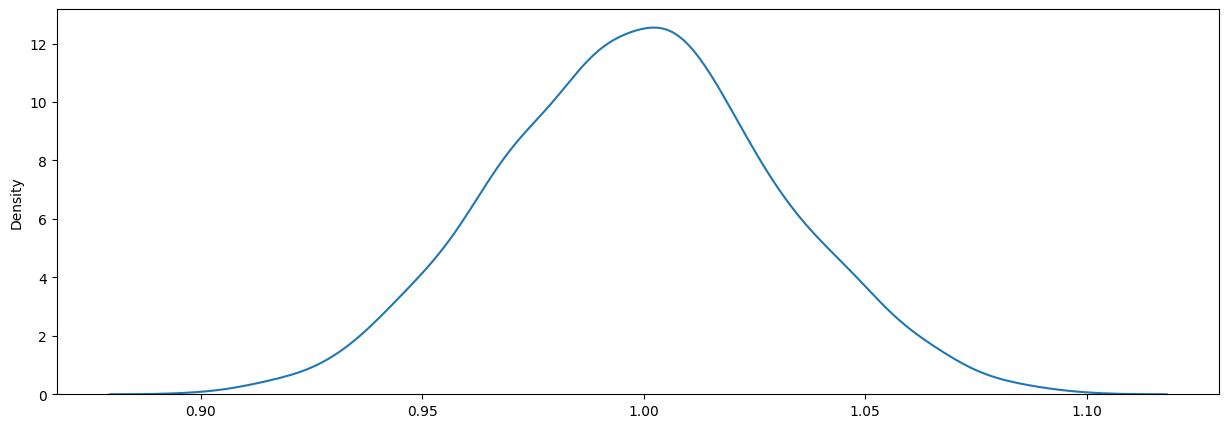

In [ ]:
sns.kdeplot(x=Gamma(1000,1000).sample(tensor([1000])).numpy());

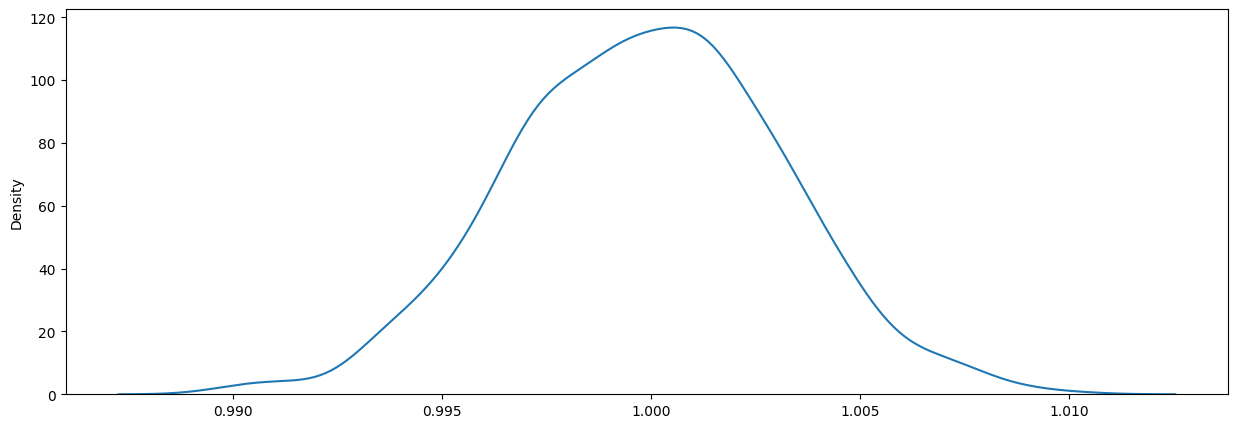

In [ ]:
sns.kdeplot(x=Gamma(100000,100000).sample(tensor([1000])).numpy());

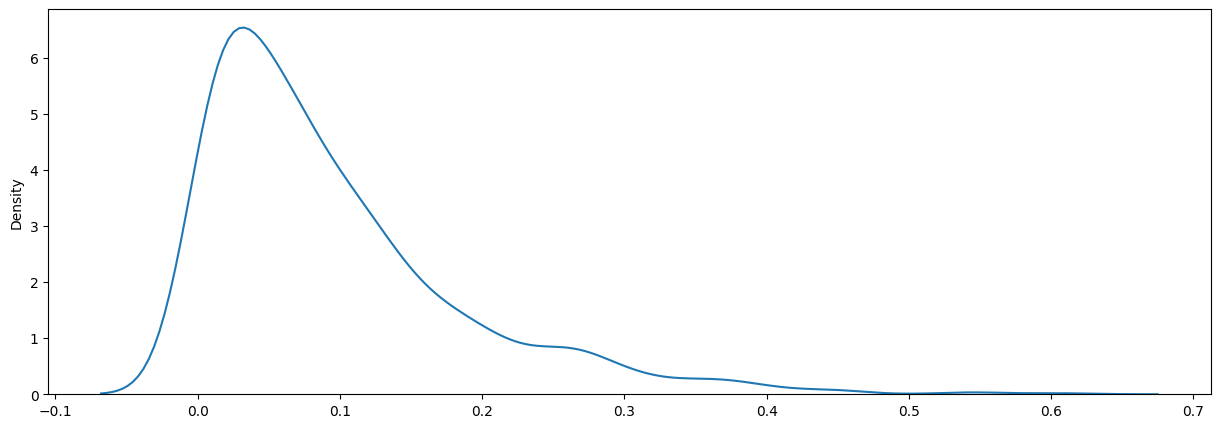

In [ ]:
sns.kdeplot(x=Gamma(1,10).sample(tensor([1000])).numpy());

In [ ]:
samples_nbd = dist.GammaPoisson(concentration=0.1, rate=0.1).sample(tensor([1000])).numpy(); # poisson with gamma parameters of shape and rate

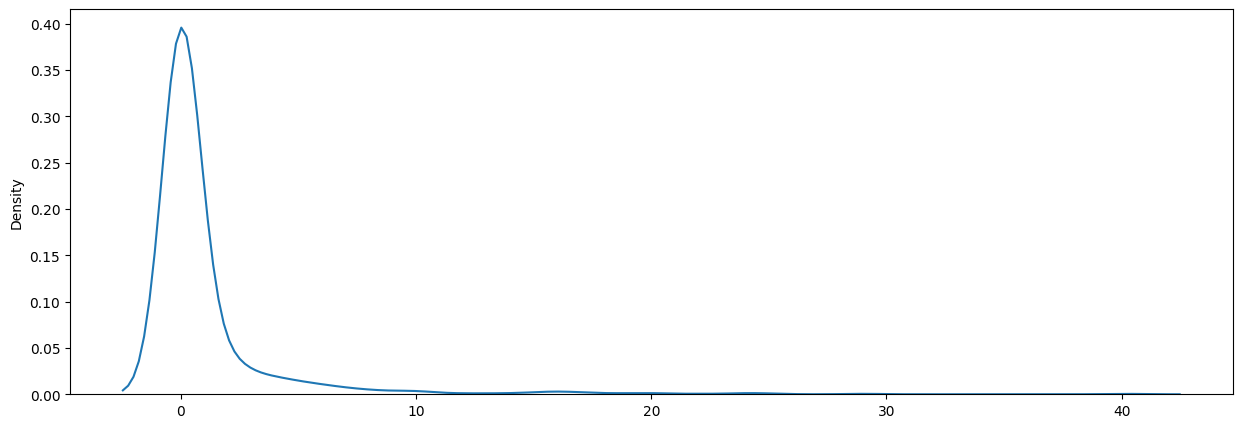

In [ ]:
sns.kdeplot(x=samples_nbd);

In [ ]:
samples_nbd.mean()

1.017

In [ ]:
samples_nbd.std()

3.2779126

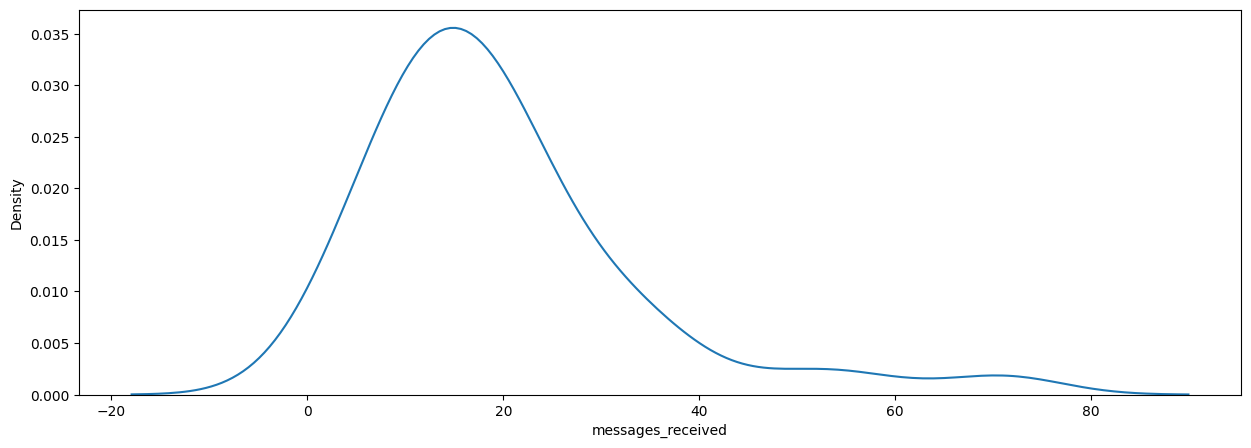

In [ ]:
sns.kdeplot(x = df['messages_received']); #actuals

In [ ]:
df['messages_received'].mean()

19.743243243243242

In [ ]:
df['messages_received'].var()

199.9742687893373

tensor([1.9404]) tensor([0.0985]) tensor([19.7000]) tensor([200.])
17.66216278076172 156.6925506591797


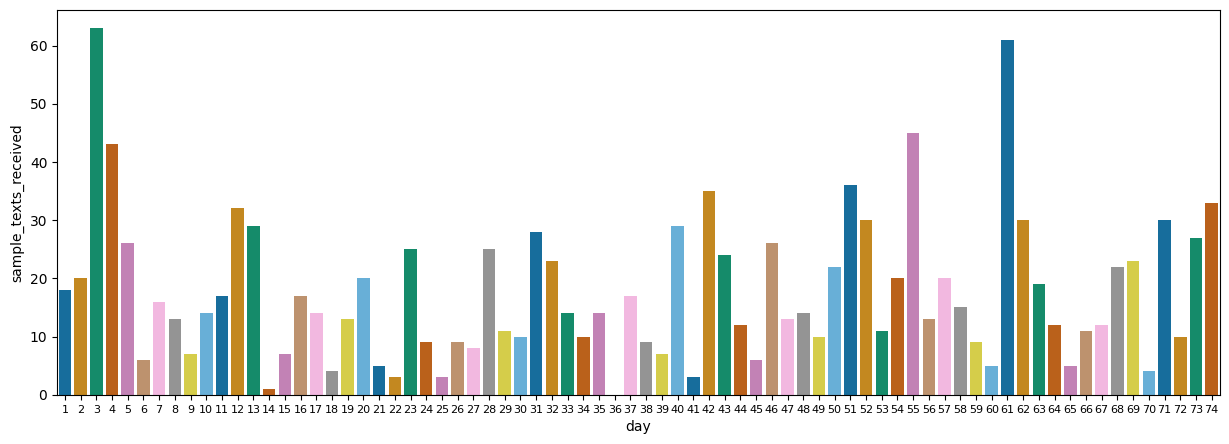

In [ ]:
a = tensor([19.7**2/200.])
b = tensor([19.7/200.])
print(a,b,a/b, a/b**2)
samples_nbd = dist.GammaPoisson(concentration=a, rate=b).sample(tensor([74])).numpy()
sample_df = pd.DataFrame({'sample_texts_received':samples_nbd.squeeze(), 'day':X['day'].copy()})
print(sample_df['sample_texts_received'].mean(), sample_df['sample_texts_received'].var())
sns.barplot(y='sample_texts_received', x='day', data=sample_df, palette='colorblind');
plt.xticks(fontsize=8);

19.743243243243242 199.9742687893373


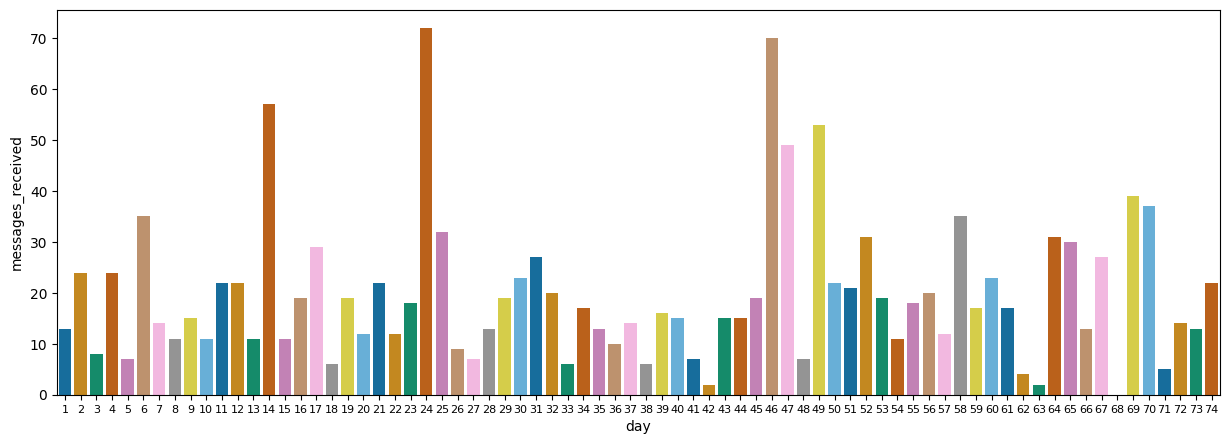

In [ ]:
print(df['messages_received'].mean(), df['messages_received'].var())
sns.barplot(y='messages_received', x='day', data=df, palette='colorblind') #actuals
plt.xticks(fontsize=8);

In [ ]:
df['messages_received'].mean(), df['messages_received'].var()

(19.743243243243242, 199.9742687893373)

In [ ]:
# So, it looks like the data is better fit with a nbd aka gamma poisson distribution. 
# Let's try a model that has priors starting from the mean of these parameters of a and b 

In [ ]:
data = tensor(X['messages_received'].values, dtype=torch.float)
data.size()

torch.Size([74])

In [ ]:
data.mean(), data.var()

(tensor(19.7432), tensor(199.9743))

In [ ]:
def model(data, m = data.mean(), v = data.var() ):
    # a = m**2/v
    # b = m/v
    # alpha_a = v/m**2
    # alpha_b = v/m
    a = pyro.sample("a", dist.Exponential(v/m**2)) # prior for a
    b = pyro.sample("b", dist.Exponential(v/m)) # prior for b

    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.GammaPoisson(a, b), obs=data)

In [ ]:
from pyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [ ]:
def train(model, guide, lr=0.01, n_steps=4000):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")
    print(f"Final Elbo loss: {elbo}")

In [ ]:
%%time
train(model, guide)

Elbo loss: 290.3669202923775
Elbo loss: 289.8972592949867
Elbo loss: 289.4570038318634
Elbo loss: 289.6415994167328
Elbo loss: 290.38794016838074
Elbo loss: 289.74164098501205
Elbo loss: 289.52730667591095
Elbo loss: 289.2687820196152
Final Elbo loss: 289.7657044529915
CPU times: user 17.6 s, sys: 31.5 ms, total: 17.7 s
Wall time: 17.8 s


In [ ]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape((num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if k != "obs"}

In [ ]:
svi_samples.keys()

dict_keys(['a', 'b'])

In [ ]:
guide.quantiles([0.05,0.50,0.95])

{'a': tensor([1.9375, 2.4906, 3.2016]), 'b': tensor([0.1082, 0.1253, 0.1450])}

In [ ]:
data.mean()**2/data.var(), data.mean()/data.var()

(tensor(1.9492), tensor(0.0987))

## Let's do MCMC

In [ ]:
kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=3)
posterior = MCMC(kernel, num_samples=1500, warmup_steps=500)
posterior.run(data);

Sample: 100%|██████████| 2000/2000 [00:16, 120.21it/s, step size=2.96e-01, acc. prob=0.914]


In [ ]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in posterior.get_samples().items()}
alpha_a_samples = hmc_samples['a']
alpha_b_samples = hmc_samples['b']


In [ ]:
data.size(0)

74

tensor(1.9492)


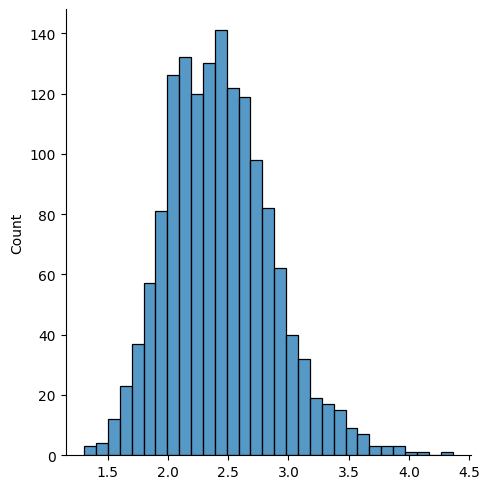

In [ ]:
print(data.mean()**2/data.var())
sns.displot(data=alpha_a_samples);

tensor(0.0987)


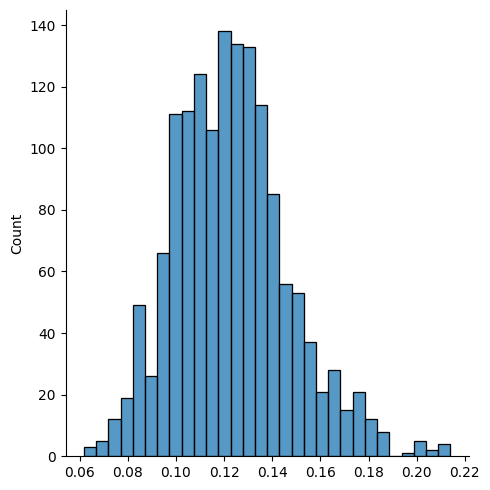

In [ ]:
print(data.mean()/data.var())
sns.displot(data=alpha_b_samples);